/var/folders/rx/s42f27kn5j5ddqzlhz7qr2yw0000gn/T/ipykernel_27532/572421457.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'] = df['Close'].fillna(method='ffill').fillna(method='bfill')
/Users/ytsang/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Train Loss: 0.0778
Epoch 2/50, Train Loss: 0.0130
Epoch 3/50, Train Loss: 0.0075
Epoch 4/50, Train Loss: 0.0056
Epoch 5/50, Train Loss: 0.0036
Epoch 6/50, Train Loss: 0.0031
Epoch 7/50, Train Loss: 0.0033
Epoch 8/50, Train Loss: 0.0023
Epoch 9/50, Train Loss: 0.0024
Epoch 10/50, Train Loss: 0.0019
Epoch 11/50, Train Loss: 0.0027
Epoch 12/50, Train Loss: 0.0019
Epoch 13/50, Train Loss: 0.0017
Epoch 14/50, Train Loss: 0.0018
Epoch 15/50, Train Loss: 0.0019
Epoch 16/50, Train Loss: 0.0017
Epoch 17/50, Train Loss: 0.0016
Epoch 18/50, Train Loss: 0.0018
Epoch 19/50, Train Loss: 0.0016
Epoch 20/50, Train Loss: 0.0018
Epoch 21/50, Train Loss: 0.0014
Epoch 22/50, Train Loss: 0.0011
Epoch 23/50, Train Loss: 0.0018
Epoch 24/50, Train Loss: 0.0014
Epoch 25/50, Train Loss: 0.0012
Epoch 26/50, Train Loss: 0.0013
Epoch 27/50, Train Loss: 0.0011
Epoch 28/50, Train Loss: 0.0017
Epoch 29/50, Train Loss: 0.0013
Epoch 30/50, Train Loss: 0.0013
Epoch 31/50, Train Loss: 0.0015
Epoch 32/50, Trai

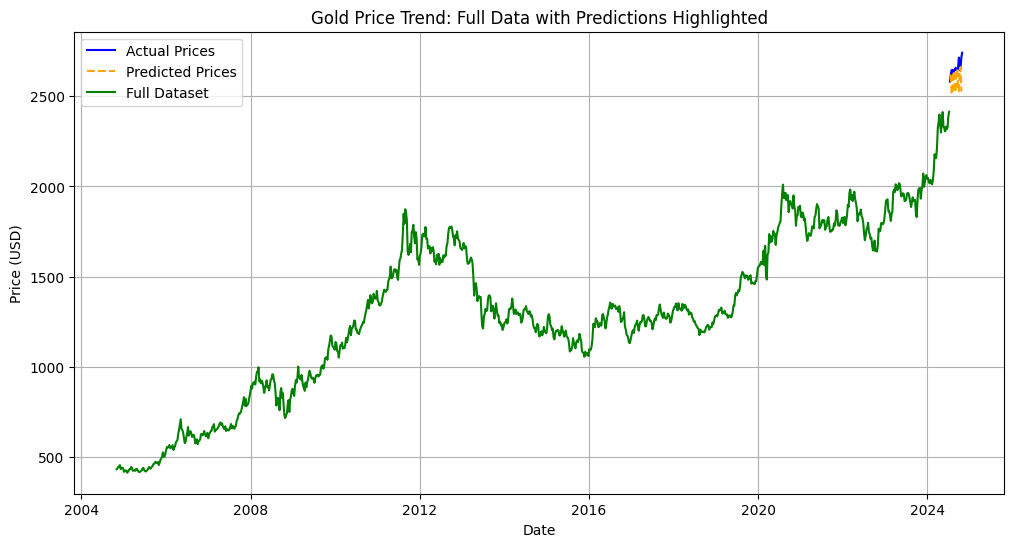

In [4]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

# Load and clean the dataset
file_path = 'gold_dec24(GC=F)_1wk.csv'
df = pd.read_csv(file_path, skiprows=3, names=['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], header=None)

# Parse dates and set as index
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)

# Handle missing values in the 'Close' column
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Close'] = df['Close'].fillna(method='ffill').fillna(method='bfill')

# Normalize the data (both inputs and outputs)
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

# Create sequences for supervised learning
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 4):  # Ensure enough data for y
        X.append(data[i:i + seq_length])  # Input sequence of length seq_length
        y.append(data[i + seq_length:i + seq_length + 4])  # Next 4 steps as output
    return np.array(X), np.array(y)

seq_length = 12  # Use 12 weeks of data to predict the next values
data = df['Close'].values
X, y = create_sequences(data, seq_length)

# Convert to PyTorch tensors and add channel dimension (for single feature)
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Shape: (batch_size, sequence_length, 1)
y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (batch_size, 4)

# Split into train/validation sets (last 4 points for evaluation)
train_val_size = len(X_tensor) - 4  # Last 4 points for evaluation
train_val_dataset = TensorDataset(X_tensor[:train_val_size], y_tensor[:train_val_size])
eval_dataset = TensorDataset(X_tensor[train_val_size:], y_tensor[train_val_size:])

# Create DataLoaders for batching
train_loader = DataLoader(train_val_dataset, batch_size=16, shuffle=True)

# Define Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_encoder_layers=3):
        super(TransformerModel, self).__init__()
        self.linear_in = nn.Linear(input_dim, d_model)  # Project input features to d_model dimensions
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.fc_out = nn.Linear(d_model, 4)  # Output size is now 4 for multi-step prediction

    def forward(self, src):
        src = self.linear_in(src)  # Project input to d_model dimensions
        src = src.permute(1, 0, 2)  # Change to (sequence_length, batch_size, d_model)
        encoder_output = self.transformer_encoder(src)
        
        # Take the last output for prediction and pass through fully connected layer
        output = self.fc_out(encoder_output[-1])
        return output

model = TransformerModel()

# Define loss function and optimizer with weight decay (L2 regularization)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop with validation printing
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    # Training phase
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Zero gradients
        
        # Forward pass
        predictions = model(X_batch)  
        
        # Calculate loss
        loss = criterion(predictions.squeeze(), y_batch)
        
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}")

# Evaluate on the last points (evaluation set)
model.eval()
eval_preds = []
eval_actuals = []

with torch.no_grad():
    for X_eval, y_eval in eval_dataset:
        eval_predictions = model(X_eval.unsqueeze(0))  
        eval_preds.append(eval_predictions.numpy())
        eval_actuals.append(y_eval.numpy())

# Convert predictions and actuals to numpy arrays for MAPE calculation
eval_preds_scaled = np.array(eval_preds).reshape(-1)
eval_actuals_scaled = np.array(eval_actuals).reshape(-1)

# Calculate MAPE for evaluation set (last points)
mape = np.mean(np.abs((eval_actuals_scaled - eval_preds_scaled) / eval_actuals_scaled)) * 100

print(f"Evaluation MAPE (Last-4 Points): {mape:.2f}%")

# Inverse transform predictions to original scale for better interpretability
eval_preds_original_scale = scaler.inverse_transform(eval_preds_scaled.reshape(-1, 1))
eval_actuals_original_scale = scaler.inverse_transform(eval_actuals_scaled.reshape(-1, 1))

print("Evaluation Predictions (Original Scale):", eval_preds_original_scale.flatten())
print("Evaluation Actuals (Original Scale):", eval_actuals_original_scale.flatten())

# Plot full data with predicted points highlighted (original scale)
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(eval_actuals_original_scale):], eval_actuals_original_scale.flatten(), label='Actual Prices', color='blue')
plt.plot(df.index[-len(eval_preds_original_scale):], eval_preds_original_scale.flatten(), label='Predicted Prices', color='orange', linestyle='--')
plt.plot(df.index[:-len(eval_actuals_original_scale)], scaler.inverse_transform(df['Close'].values[:-len(eval_actuals_original_scale)].reshape(-1, 1)), label='Full Dataset', color='green')
plt.title('Gold Price Trend: Full Data with Predictions Highlighted')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()
